In [1]:
import os
os.listdir()


['.ipynb_checkpoints', 'churn_model.ipynb', 'churn_sql_features.csv']

In [2]:
!pip install shap


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import shap


In [4]:
df = pd.read_csv("churn_sql_features.csv")
df.head()

,customerID,tenure,MonthlyCharges,TotalCharges,short_tenure_flag,high_charge_flag,month_to_month_flag,manual_payment_flag,Churn
0,7590-VHVEG,1,29.85,29.85,1,0,1,1,No
1,5575-GNVDE,34,56.95,1889.50,0,0,0,1,No
2,3668-QPYBK,2,53.85,108.15,1,0,1,1,Yes
3,7795-CFOCW,45,42.30,1840.75,0,0,0,0,No
4,9237-HQITU,2,70.70,151.65,1,0,1,1,Yes


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customerID           7043 non-null   object 
 1   tenure               7043 non-null   int64  
 2   MonthlyCharges       7043 non-null   float64
 3   TotalCharges         7032 non-null   float64
 4   short_tenure_flag    7043 non-null   int64  
 5   high_charge_flag     7043 non-null   int64  
 6   month_to_month_flag  7043 non-null   int64  
 7   manual_payment_flag  7043 non-null   int64  
 8   Churn                7043 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 495.3+ KB


In [6]:
df.isnull().sum()


customerID              0
tenure                  0
MonthlyCharges          0
TotalCharges           11
short_tenure_flag       0
high_charge_flag        0
month_to_month_flag     0
manual_payment_flag     0
Churn                   0
dtype: int64

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

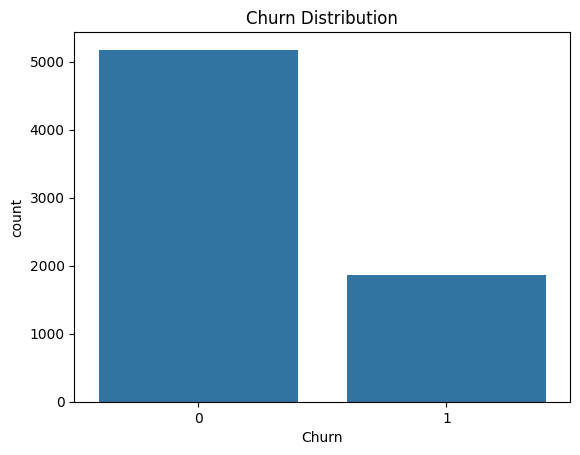

In [8]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


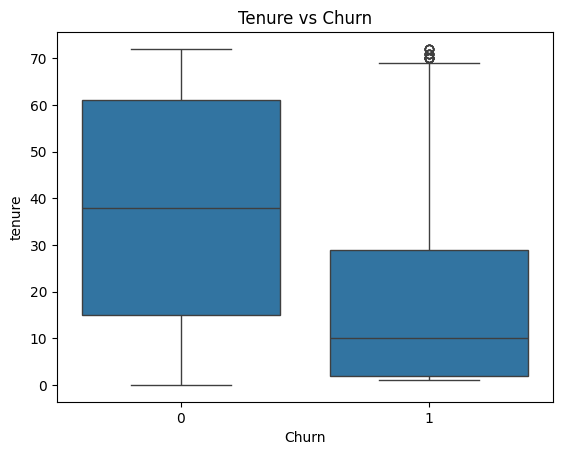

In [9]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()


In [10]:
features = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'short_tenure_flag',
    'high_charge_flag',
    'month_to_month_flag',
    'manual_payment_flag'
]

X = df[features]
y = df['Churn']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]
print(classification_report(y_test, y_pred_lr))
roc_auc_score(y_test, y_prob_lr)


              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1552
           1       0.49      0.80      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.73      0.74      2113



0.8290779995222082

In [14]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
roc_auc_score(y_test, y_prob_rf)


              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1552
           1       0.52      0.75      0.61       561

    accuracy                           0.75      2113
   macro avg       0.70      0.75      0.71      2113
weighted avg       0.79      0.75      0.76      2113



0.8279633432567028

In [16]:
print(X_test.shape)


(2113, 7)


  0%|          | 0/300 [00:00<?, ?it/s]

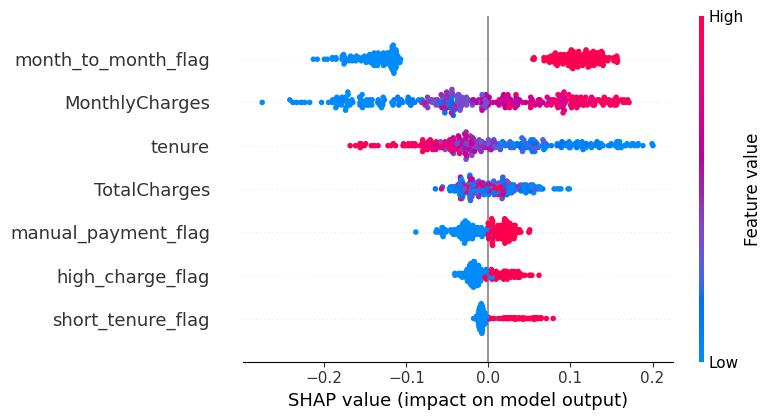

In [17]:
# # explainer = shap.Explainer(rf, X_train)
# # shap_values = explainer(X_test)
# # shap.summary_plot(shap_values, X_test)
# explainer = shap.TreeExplainer(
#     rf,
#     X_train,
#     feature_perturbation="interventional"
# )

# shap_values = explainer.shap_values(
#     X_test,
#     check_additivity=False
# )

# shap.summary_plot(shap_values[1][:,:-1], X_test)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def model_predict(X):
    return rf.predict_proba(X)[:, 1]

background = X_train.sample(100, random_state=42)

explainer = shap.KernelExplainer(
    model_predict,
    background
)

shap_values = explainer.shap_values(
    X_test.iloc[:300]   # limit for speed (standard practice)
)

shap.summary_plot(
    shap_values,
    X_test.iloc[:300]
)


In [18]:
print(shap_values[1].shape)
print(X_test.shape)


(7,)
(2113, 7)


In [19]:
df['churn_probability'] = rf.predict_proba(X)[:,1] * 100
def risk_bucket(score):
    if score >= 70:
        return 'High Risk'
    elif score >= 40:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['risk_segment'] = df['churn_probability'].apply(risk_bucket)


In [20]:
df.groupby('risk_segment')['Churn'].mean()
df['risk_segment'].value_counts()


risk_segment
Low Risk       3828
Medium Risk    1790
High Risk      1425
Name: count, dtype: int64

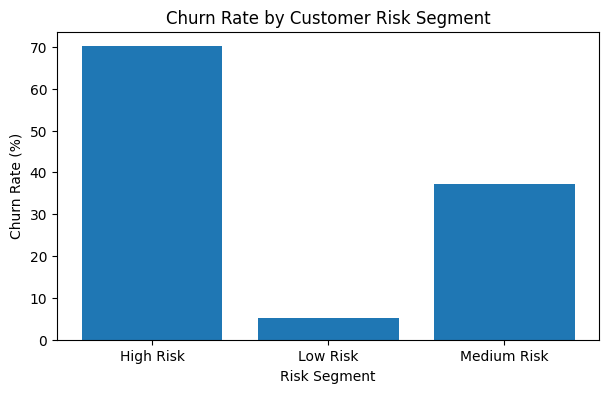

In [21]:
kpi_df = (
    df.groupby("risk_segment")["Churn"]
    .mean()
    .reset_index()
)

kpi_df["Churn"] = kpi_df["Churn"] * 100
kpi_df


import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(
    kpi_df["risk_segment"],
    kpi_df["Churn"]
)

plt.title("Churn Rate by Customer Risk Segment")
plt.xlabel("Risk Segment")
plt.ylabel("Churn Rate (%)")

plt.show()
